# NPoS Economics V7: Sequential Phragmen
### **Author**: Eray Sabancilar
### **Last updated**: 31.03.2020

In this notebook, we analyze a dynamic microeconomic model of the NPoS agents (nominators and validators). For a detailed description see:

https://hackmd.io/lds-5KCSRL6zVazm4p16TA?view

## V7 Summary

In this version, we introduce validator assignment in each era using an implementation of Alistair's sequential Phragmen python code (https://github.com/w3f/consensus/blob/master/NPoS/simplePhragm%C3%A9n.py) into our NPoS economic model.

### Parameters

In our simulation, we use the following set of parameter values.

| Parameters                  | Values                                        |
| --------                    | --------                                      | 
| Initial Nominator & Validator Wealths   | $w_0$: Taken from Kusama Accounts              | 
| Fraction of Initial Stakes  | $f_0 = 0.5$                                   |
| Inflation Parameters        | $I_0 = 0.025$, $\chi_{\rm ideal} = 0.5$, $r_{\rm ideal} = 0.2$, $d_{\rm shift} = 0.05$| 
| Era                         | $t=1$ day                              |
| Total Time                  | $T = 10$ years                         |
| Opportunity Cost of Capital | $R_{\rm opp}^{\rm ann} = 0.2$         |
| Staking Adjustment Speed    | $\alpha = 100$                         | 
| Stickiness Probability      | $p_s = 1/7$ (~once a week)             |
| Unresponsiveness Probability| $p_u = 1/60$ (~once every other 2 months)  |
| Equivocation Probability    | $p_e = 1/240$ (~once every other 8 months) |
| Number of New Accounts | $N_{\rm new} = 1000$ |
| Amount in New Accounts | $W_{\rm new}  = 50$ KSM |
| Validator Commission Fee | $fee_v = 0.2$|
| Number of Validators | $N_v = 300$ |
| Maximum Number of Validators per Nominator| $N_{v_{max}}$ = 16|

### Import Python Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import random

## 1. Kusama Genesis Balances

### 1.1. Importing Kusama Genesis Address & Balance Data

In [2]:
# Import data
data = pd.read_csv("kusamaGenesisBalances.csv")

# Convert balances into units of Kusamas
data['Balance'] = data['Balance']*(10**(-12))

# Reorder data by balance amounts
data = data.sort_values(by='Balance', ascending=False)
nAccounts = data.values.shape[0]
print("The number of all accounts at genesis is {}.".format(nAccounts))

# Total and median amounts in the balances
sumKSM = data["Balance"].sum()
print("The total amount in the balances is {} million Kusamas.".format(round(sumKSM/10**6,3)))
medianKSM = round(data["Balance"].median(),3)
print("The median account balance is {} Kusamas.".format(medianKSM))

The number of all accounts at genesis is 381.
The total amount in the balances is 3.433 million Kusamas.
The median account balance is 211.051 Kusamas.


### 1.2. Exploratory Data Analysis

In [3]:
# The first few rows of the sorted dataset
data.head(4)

,Address,Balance
118,5HDxC9wVPShJZ3UD7mF21pysMFL8qmYDSdspaeY1tWtZQGcK,709346.898
1,5DwXnSMVwLXBZoEfJDw9LMXAb1Q4pv1yp8DrFzNWqAzuJHPo,369340.969
179,5ENzuYss9R3tJzCFbTp3MnoMwShTMpCP9dQ5DQ7Ve6SQdCpL,84420.792
380,5GYUNkqs6gWBi5xxvvG2vBry6o2oLduFXSvTQCwjxF9nhREe,75000.000


In [4]:
# The last few rows of the sorted dataset
data.tail(4)

,Address,Balance
269,5HjgWVF8CuP3xMsBmg4SKfK8Wvbhi6xoREs63YKfwZMAqy2r,0.01
311,5HNNjonNAftjHTToLpf5iyYeir2NDYnBdcRiwyJkP4Ra76QW,0.01
310,5CAWmjDvXUxrwThznrsMy5WwpH714NwJcMirqXQifLXQw4Li,0.01
298,5G6GU1xmqxmLmPQ2L9pXtqNiRdcGG31cbq63mf3TU7Z4BPDU,0.01


In [5]:
# cleanData removes the KSM accounts with balances smaller than the specified threshold
# ->Inputs:
# data: KSM account addresses and balances as a pandas dataframe
# threshold: minimum KSM balance above which is kept in the clean dataset 
# Output->: 
# clean dataset as a pandas dataframe
def cleanData(data,threshold):
    # Indicies of balances without the threshold balances
    idx = data["Balance"].loc[data["Balance"] != threshold].index 

    # Data without Kusama accounts with balances larger than the threshold
    dataClean = data.loc[idx]
    return dataClean

In [6]:
# Remove accounts with balances of 0.01 or less KSM 
threshold = 0.01
dataClean = cleanData(data,threshold)
# Check the first and the last few rows of ordered balances
display(dataClean.head(4))
display(dataClean.tail(4))

,Address,Balance
118,5HDxC9wVPShJZ3UD7mF21pysMFL8qmYDSdspaeY1tWtZQGcK,709346.898
1,5DwXnSMVwLXBZoEfJDw9LMXAb1Q4pv1yp8DrFzNWqAzuJHPo,369340.969
179,5ENzuYss9R3tJzCFbTp3MnoMwShTMpCP9dQ5DQ7Ve6SQdCpL,84420.792
380,5GYUNkqs6gWBi5xxvvG2vBry6o2oLduFXSvTQCwjxF9nhREe,75000.000


,Address,Balance
193,5H1DvSQVg8wGHiiP2ugdHQQUU7TUNAcL7cg6XYsnAFCDz63f,5.276
232,5DLB96CJ62oWhfUiLNN36tM9KmpU789dW5qRzCB3PTg2VBYD,4.588
19,5EyErcfEJTjKJjE4tDiPZNyAhCAqpckkNPo9Ncjod8yhZr7Z,2.661
258,5C5CHDNR2mgsy48eopGp1BcZ29EYM5dxMBNEAe5VpX4cPjKY,0.825


In [7]:
# Number of accounts in the clean dataset
nAccountsClean = dataClean.values.shape[0]
print("The number of accounts at genesis with more than 0.01 KSM is {}.".format(nAccountsClean))
print("Thus, there are {} accounts with 0.01 KSM that we drop in what follows.".format(nAccounts - nAccountsClean))

The number of accounts at genesis with more than 0.01 KSM is 339.
Thus, there are 42 accounts with 0.01 KSM that we drop in what follows.


In [8]:
# plotBalances plots the histogram of the Kusama accounts at genesis
# ->Inputs:
# data: account balance data
# figureName: Figure name as a string
# Output->:
# Histogram of the Kusama genesis account balances as a pdf file
def plotBalances(data,figureName):
    plt.figure(figsize=(20,8))
    plt.hist(data,300)
    plt.xlabel('Kusama Balances (KSM)',fontsize = 16)
    plt.ylabel('Number of Kusama Accounts',fontsize = 16)
    plt.title('Kusama Genesis Balance Distribution',fontsize = 20)
    plt.xticks(fontsize = 16)
    plt.yticks(fontsize = 16)
    #axes = plt.gca()
    #axes.set_xlim([xmin,xmax])
    #axes.set_ylim([ymin,ymax])
    plt.savefig(figureName)
    return plt.show()

In [9]:
#outlierShare
round((dataClean["Balance"][1]+dataClean["Balance"][2])*100/sumKSM,2)

12.22

We observe two outlier account balances with 709,346.898 & 369,340.969 KSM, whereas the lowest balance has 0.825 KSM. The largest two balances hold 12.22 % share of the whole Kusamas at genesis.

## 2. Initial Conditions and Parameters

### 2.1. Parameters

In [10]:
# Fraction of stakes from the Kusama genesis balances
f_0 = 0.5
# Inflation parameters
I_0 = 0.025 
chi_ideal = 0.5
r_ideal = 0.2
d_shift = 0.05
# Total time length
year = 10
T = 365*year
# Annual opportunity cost of capital
R_opp = 0.2
# Staking adjustment speed
alpha = 100
# Staking stickiness parameter: update roughly once a week
p_s = 1/7
# Unresponsiveness parameter: occurs roughly once every other 2 months
p_u = 1/60
# Equivocation parameter: occurs roughly once every other 8 months
p_e = 1/240
# Number of new accounts
N_new = 1000
# Amount in new accounts
w_new = 50
# Commission fee fraction charged by validators
fee_v = 0.2
# Number of validators
N_v = 300
# Maximum Number of Validators per Nominator
N_v_max = 16

### 2.2. Add New Accounts

In [11]:
# addNewAccounts adds a number of new accounts with the same balances to the genesis accounts
# -> Inputs: 
# N_new: Number of new accounts to be added
# w_new: Balance of new accounts in KSM
# <- Output:
# A vector of new account balances
def addNewAccounts(N_new,w_new):
    w_new_0 = np.multiply(w_new, np.ones((N_new)))
    return w_new_0

In [12]:
# Add new accounts with small balances
w_new_0 = addNewAccounts(N_new,w_new)

### 2.2. The Initial Wealth Distribution

In [13]:
# Initial wealth
w_0 = np.sort(np.concatenate((dataClean['Balance'].values,w_new_0)))

### 2.4. Number of Nominators

In [14]:
# Number of validators and nominators
N = w_0.shape[0]
N_v = 300
# Number of Nominators
N_n = N - N_v

### 2.3. Bootstraping a Set of Validators and Nominators

In [15]:
# Create an array of indices for all the accounts
idx_N = np.array(range(0, N)) 
# Generate random indices corresponding to the validator account balances
idx_v = np.sort(random.sample(range(0, N), N_v))
# Set the remaning indices for nominators
idx_n = np.delete(idx_N, idx_v)
# Bootstrap validators from the initial distribution
w_0_v = np.take(w_0, idx_v)
# Set the remaning accounts as nominators
w_0_n = np.take(w_0, idx_n)
# Merge initial wealth
w_0 = np.zeros(N)
w_0[0:N_n] = w_0_n 
w_0[N_n:N_n+N_v] = w_0_v

### 2.4. Initial Staking Distribution

In [16]:
# Initial validator staking
d_0_v = f_0*w_0_v
# Initial nominator staking
d_0_n = f_0*w_0_n
# Merge initial stakes into a single ordered vector
d_0 = np.zeros(N)
d_0[0:N_n] = d_0_n 
d_0[N_n:N_n+N_v] = d_0_v

### 2.5. Redefining Nominator and Validator Indices

In [17]:
idx_n = np.array(range(0, N_n)) 
idx_v = np.array(range(N_n, N_n+N_v))

### 2.6. Assigning Validators to Nominators Randomly

In [18]:
# Assign nominators to validators randomly by allowing assignment to the same validators using replace=True 
# since N_n > N_v and store them into an index vector A_v 
def assignValidator(idx_v, N_n):
    A_v = np.random.choice(idx_v, N_n, replace=True, p=None)
    return A_v

# 3. Function Definitions

### 3.1. Inflation and Interest Rates

In [19]:
# Annual inflation rate as a function of the staking rate x
# ->Input parameters:
# I_0: inflation 
# chi_ideal: ideal staking rate
# r_ideal: ideal interest rate
# d_shift: shift parameter
# Input variable:
# x: staking rate as a number
# Output->:
# annualInflation: annual inflation rate
def annualInflation(I_0, chi_ideal, r_ideal, d_shift, x):
    if 0 <= x <= chi_ideal:
        I = I_0 + (r_ideal - I_0/chi_ideal)*x
    if chi_ideal < x <= 1:
        I = I_0 + (r_ideal*chi_ideal - I_0)*2**((chi_ideal - x)/d_shift)
    return I

# Annual interest rate
# ->Input parameters: I_0, chi_ideal, r_ideal, dinf
# Input variable:
# x: staking rate as a number
# Output->:
# annualInterest: annual inflation rate
def annualInterest(I_0, chi_ideal, r_ideal, d_shift, x):
    if 0<= x < 0.00001:
        r = 2.62
    else:
        r = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x)/x
    return r

### 3.2. Plot of Inflation and Interest Rates

In [20]:
# plotInflationInterestRate produces inflation and interest rate curves for all range of staking rates
# ->Inputs:
# ymin_inf, ymax_inf, ymin_r, ymax_r: y axis limits for inflation and interest rate plots respectively
# Outputs->:
# Annual inflation and interest rates as pdf files
def plotInflationInterestRate(ymin_inf, ymax_inf, ymin_r, ymax_r):
    xlin = np.linspace(0, 1, 100, endpoint=True)
    Ilin = np.zeros(len(xlin))
    rlin = np.zeros(len(xlin))
    for i in range(0,len(xlin)):
        Ilin[i] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, xlin[i])
        rlin[i] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, xlin[i])
    plot_title = ['Annual Inflation Rate','Annual Interest Rate']
    plot_variable = [Ilin,rlin]
    ylims = [[ymin_inf, ymax_inf],[ymin_r, ymax_r]]
    for j in range(0,len(plot_title)):
        plt.figure(figsize=(10,6))
        plt.plot(xlin, plot_variable[j],"-r")
        plt.xlabel('Staking Rate: x', fontsize=16)
        plt.ylabel(plot_title[j], fontsize=16)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        axes = plt.gca()
        axes.set_ylim(ylims[j])
        axes.set_xlim([0,1])
        plt.savefig(plot_title[j] + '.pdf')

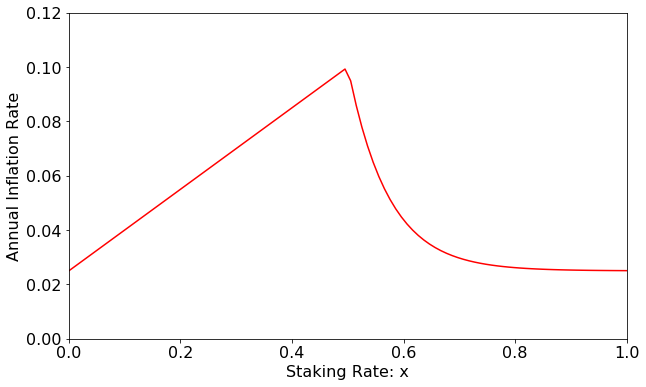

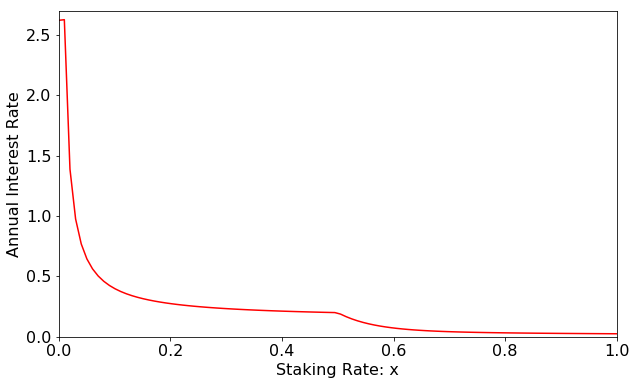

In [21]:
# Plot the annual NPoS inflation and interest rate curves
ymin_inf, ymax_inf, ymin_r, ymax_r = 0, 0.12, 0, 2.7
plotInflationInterestRate(ymin_inf, ymax_inf, ymin_r, ymax_r)

## 4 Sequential Phragmen

Alistair's original python code can be found here:
https://github.com/w3f/consensus/blob/master/NPoS/simplePhragm%C3%A9n.py

### 4.1. Sequantial Phragmen with Postprocessing

In [22]:
#from itertools import count
class edge:
    def __init__(self,nomid,valiid):
        self.nomid=nomid
        self.valiid=valiid
        #self.validator
        self.load=0

class nominator:
    def __init__(self,votetuple):
        self.nomid=votetuple[0]
        self.budget=votetuple[1]
        self.edges=[edge(self.nomid,valiid) for valiid in votetuple[2]]
        self.load=0

class candidate:
    def __init__(self,valiid,valindex):
        self.valiid = valiid
        self.valindex=valindex
        self.approvalstake=0
        self.elected=False
        self.backedstake=0
        self.score=0

def setuplists(votelist):
    #Instead of Python's dict here, you can use anything with O(log n) addition and lookup.
    #We can also use a hashmap like dict, by generating a random constant r and useing H(canid+r)
    #since the naive thing is obviously attackable.
    nomlist = [nominator(votetuple) for votetuple in votelist]
    candidatedict=dict()
    candidatearray=list()
    numcandidates=0
    #Get an array of candidates. ]#We could reference these by index
    #rather than pointer
    for nom in nomlist:
        for edge in nom.edges:
            valiid = edge.valiid
            if valiid in candidatedict:
                edge.candidate=candidatearray[candidatedict[valiid]]
            else:
                candidatedict[valiid]=numcandidates
                newcandidate=candidate(valiid,numcandidates)
                candidatearray.append(newcandidate)
                edge.candidate=newcandidate
                numcandidates += 1
    return(nomlist,candidatearray)
    

def seqPhragmen(votelist,numtoelect):
    nomlist,candidates=setuplists(votelist)
    #Compute the total possible stake for each candidate
    for nom in nomlist:
        for edge in nom.edges:
            edge.candidate.approvalstake += nom.budget
        
    electedcandidates=list()
    for round in range(numtoelect):
        for candidate in candidates:
            if not candidate.elected:
                candidate.score=1/candidate.approvalstake
        for nom in nomlist:
            for edge in nom.edges:
                if not edge.candidate.elected:
                    edge.candidate.score +=nom.budget * nom.load / edge.candidate.approvalstake
        bestcandidate=0
        bestscore = 1000 #should be infinite but I'm lazy
        for candidate in candidates:
            if not candidate.elected and candidate.score < bestscore:
                bestscore=candidate.score
                bestcandidate=candidate.valindex
        electedcandidate=candidates[bestcandidate]
        electedcandidate.elected=True
        electedcandidate.electedpos=round
        electedcandidates.append(electedcandidate)
        for nom in nomlist:
            for edge in nom.edges:
                if edge.candidate.valindex == bestcandidate:
                    edge.load=electedcandidate.score - nom.load
                    nom.load=electedcandidate.score

    for candidate in electedcandidates:
        candidate.backedstake=0

    for nom in nomlist:
            for edge in nom.edges:
                if nom.load > 0.0:
                    edge.backingstake = nom.budget * edge.load/nom.load
                    edge.candidate.backedstake += edge.backingstake
                else:
                    edge.backingstake = 0
    return (nomlist,electedcandidates)

def approvalvoting(votelist,numtoelect):
    nomlist,candidates=setuplists(votelist)
    #Compute the total possible stake for each candidate
    for nom in nomlist:
        for edge in nom.edges:
            edge.candidate.approvalstake += nom.budget
            edge.backingstake = nom.budget/min(len(nom.edges),numtoelect)
            edge.candidate.backedstake += edge.backingstake
    candidates.sort( key = lambda x : x.approvalstake, reverse=True)
    electedcandidates=candidates[0:numtoelect]
    return nomlist,electedcandidates

def printresult(nomlist,electedcandidates):
    for candidate in electedcandidates:
        print(candidate.valiid," is elected with stake ",candidate.backedstake, "and score ",candidate.score)
    print()
    for nom in nomlist:
        print(nom.nomid," has load ",nom.load, "and supported ")
        for edge in nom.edges:
            print(edge.valiid," with stake ",edge.backingstake, end=" ")
        print()

def equalise(nom, tolerance):
    # Attempts to redistribute the nominators budget between elected validators
    # Assumes that all elected validators have backedstake set correctly
    # returns the max difference in stakes between sup
    
    electededges=[edge for edge in nom.edges if edge.candidate.elected]
    if len(electededges)==0:
        return 0.0
    stakeused = sum([edge.backingstake for edge in electededges])
    backedstakes=[edge.candidate.backedstake for edge in electededges]
    backingbackedstakes=[edge.candidate.backedstake for edge in electededges if edge.backingstake > 0.0]
    if len(backingbackedstakes) > 0:
        difference = max(backingbackedstakes)-min(backedstakes)
        difference += nom.budget-stakeused
        if difference < tolerance:
            return difference
    else:
        difference = nom.budget
    #remove all backing
    for edge in nom.edges:
        edge.candidate.backedstake -= edge.backingstake
        edge.backingstake=0
    electededges.sort(key=lambda x: x.candidate.backedstake)
    cumulativebackedstake=0
    lastcandidateindex=len(electededges)-1
    for i in range(len(electededges)):
        backedstake=electededges[i].candidate.backedstake
        #print(nom.nomid,electededges[i].valiid,backedstake,cumulativebackedstake,i)
        if backedstake * i - cumulativebackedstake > nom.budget:
            lastcandidateindex=i-1
            break
        cumulativebackedstake +=backedstake
    laststake=electededges[lastcandidateindex].candidate.backedstake
    waystosplit=lastcandidateindex+1
    excess = nom.budget + cumulativebackedstake -  laststake*waystosplit
    for edge in electededges[0:waystosplit]:
        edge.backingstake = excess / waystosplit + laststake - edge.candidate.backedstake
        edge.candidate.backedstake += edge.backingstake
    return difference

import random
def equaliseall(nomlist,maxiterations,tolerance):
    for i in range(maxiterations):
        for j in range(len(nomlist)):
            nom=random.choice(nomlist)
            equalise(nom,tolerance/10)
        maxdifference=0
        for nom in nomlist:
            difference=equalise(nom,tolerance/10)
            maxdifference=max(difference,maxdifference)
        if maxdifference < tolerance:
            return

def seqPhragmenwithpostprocessing(votelist,numtoelect):
    nomlist,electedcandidates = seqPhragmen(votelist,numtoelect)
    equaliseall(nomlist,2,0.1)
    return nomlist,electedcandidates
# Function: Sequential Phragmen with Postprocessing 
# nomlist,electedcandidates  = seqPhragmenwithpostprocessing(votelist,numtoelect)
# ->Inputs:
# votelist = [('Voter_1', Stake_1, ['Candiate_1', 'Candiate_2', ...]), ('Voter_2', ...)]
# numtoelect = Number of candidates to be elected
# Outputs->: 
# nomlist[i].nomid = 'Voter_i' -> Voter ID
# nomlist[i].load = load -> Load 
# nomlist[i].edges[j].valiid = 'Candidate_j'  -> Candiate ID
# nomlist[i].edges[j].backingstake = stake_j -> Stake behind candidate j
# electedcandidates[i].valiid = 'Elected Candiate i'
# electedcandidates[i].backedstake = totalStake -> total stake behind Elected Candiate i 

### 4.2. Votelist

In [23]:
# votelist function makes a voting list given the nominator 
# and validator stakes by randomly choosing a number of 
# validators to be elected and randomly picking the validators.
# The votelist includes the nominators' candidates and stakes
# as well as the validator self stakes.
# ->Inputs:
# N_n: Number of nominators
# N_v: Number of validators
# N_v_max: Number of maximum number of validators per nominator
# N: Total number of nominators and validators
# idx_n: Nominator indices
# idx_v: Validator indices
# d: Nominator and validator stakes
# Output->:
# votelist: [('Voter_1', Stake_1, ['Candiate_1', 'Candiate_2', ...]), ('Voter_2', ...), ...]
def voteList(N_n, N_v, N_v_max, N, idx_n, idx_v, d):
    # Preallocate lists
    nominatedCandidates = [None]*N_n
    nominatorVotelist = [None]*N_n
    validatorVotelist = [None]*N_v
    votelist = [None]*N
    # Randomly generate a list of integers between 1 and 16
    N_candidate = np.random.randint(1,high = N_v_max + 1, size=N_n)
    for i in range(0,N_n):
        # Randomly pick candidate indices for nominator i
        nominatedCandidates[i] = np.sort(assignValidator(idx_v, N_candidate[i]))
        nominatorVotelist[i] = (idx_n[i], d[i], nominatedCandidates[i])
    # Validators self stake
    for j in range(0,N_v):
        validatorVotelist[j] = (idx_v[j], d[N_n+j], np.array([idx_v[j]]))
    # Merge the nominator and validator votelists
    votelist[0:N_n] = nominatorVotelist
    votelist[N_n:N_n+N_v] = validatorVotelist
    return votelist

### 4.3. Setting up the Initial Votelist

In [24]:
votelist_0 = voteList(N_n, N_v, N_v_max, N, idx_n, idx_v, d_0)

### 4.4. The Initial Election Results from Sequential Phragmen

In [25]:
nomlist_0, electedcandidates_0 = seqPhragmenwithpostprocessing(votelist_0,N_v)

## 5 NPoS Economics

### 5.1. NPoS Economic Model

In [26]:
# NPoSEcononomics function calculates nominal wealth, staking process of 
# nominators and validators where validators are randomly assigned to these 
# nominators. It produces a time series of wealth, staking, inflation & interest rates.
# ->Inputs:
# I_0, chi_ideal, r_ideal, d_shift: Inflation curve parameters
# w_0: Nominator and validator initial wealth distribution
# d_0: Nominator and validator initial stake distribution
# N_n, N_v: Number of nominators and validators
# idx_n, idx_v: Nominator and validator account indices
# nomlist_0, electedcandidates_0: Initial results from the sequential Phragmen 
# T: Number of eras
# R_opp: Annual opportunity cost of capital
# alpha: Staking adjustment speed
# p_u, p_e, p_s: Probabilities of unresponsiveness, equivocation and stickiness
# fee_v: Validator commision fee fraction
# Outputs->:
# w: Wealth distribution
# p_tot: Total payouts
# x: Staking rate 
# I: Annual inflation rate
# r: Annual interest rate
def NPoSEcononomics(I_0, chi_ideal, r_ideal, d_shift,\
                    w_0, d_0,\
                    N_n, N_v,\
                    idx_n, idx_v,\
                    nomlist_0,electedcandidates_0,\
                    T, R_opp, alpha, p_s, p_u, p_e, fee_v): 
    
    # Pre-allocate w, d, p, I, r, x matrices
    # Nominal wealth of nominators and validators
    w = np.zeros((T+1,N))
    
    # Nominator, validator & total stakes backing the same validators
    d = np.zeros((T+1,N))
    d_n_v = np.zeros((T+1,N,N_v))
    d_v_tot = np.zeros((T+1,N_v))
    d_tot = np.zeros((T+1,1))
    
    # Total payouts, payouts to validators and nominators
    p_tot = np.zeros((T+1,1))
    p = np.zeros((T+1,N))
    
    # Inflation rate
    I = np.zeros((T+1,1))
    # Interest rate
    r = np.zeros((T+1,1))
    # Staking rate
    x = np.zeros((T+1,1))
    # Unit vectors of size equal to the number of nominators and validators
    idN = np.ones((1,N))
    
    # Vectors of zeros of size equal to the number of nominators and validators
    zeroN_n = np.zeros((1,N_n))
    zeroN_v = np.zeros((1,N_v))
    
    # Nominator and validator slashing, and total slashing
    s_n_v = np.zeros((T+1,N,N_v))
    s = np.zeros((T+1,N))
    
    # Set initial values
    w[0,:] = w_0
    d[0,:] = d_0
    d_tot[0] = np.sum(d_0)
    x[0] = (np.sum(d_0))/(np.sum(w_0))
    I[0] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x[0])
    r[0] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, x[0])
    nomlist = nomlist_0
    electedcandidates = electedcandidates_0
    
    # Update values of these matrices in time
    t = 1
    while t <= T:
        # Unresponsiveness process determined by a Bernoulli variable with probability p_u
        u = np.random.binomial(1, p_u, N_v)
        # Number of unresponsiveness per era
        k_u = np.sum(u)
        # Slashing fraction for unresponsiveness
        f_u = 0.05*min((3*(k_u-1)/N_v),1)
        
        # Equivocation process determined by a Bernoulli variable with probability p_e
        e = np.random.binomial(1, p_e, N_v)
        # Number of unresponsiveness per era
        k_e = np.sum(e)
        # Slashing fraction for unresponsiveness
        f_e = min(((3*k_e/N_v)**2),1)
        
        # Slashing validators at time t-1
        s_n_v[t-1,:,:] = np.multiply(d_n_v[t-1,:,:],u*f_u + e*f_e)
        # No slashing at genesis
        s_n_v[0,:,:] = np.zeros((N,N_v))
        
        # Save stakes backing validators
        for candidate in electedcandidates:
            d_v_tot[t-1,candidate.valiid - idx_v[0]] = candidate.backedstake
        
        # Save stakes by each nominator n to a given nominator v
        for nom in nomlist:
            for edge in nom.edges:
                # Stake matrix of each time step for nominator n and validator v
                d_n_v[t-1,nom.nomid,edge.valiid-idx_v[0]] = edge.backingstake
        
        # Calculate total stakes from all nominators and validators at time t-1
        d_tot[t-1] = np.sum(d_v_tot[t-1,:])
        
        # Calculate total payout at time t
        p_tot[t] = d_tot[t-1]*(r[t-1]/365)
          
        # Calculate payouts assuming each validator (and nominators backing it)
        # Payout of nominators backing validator i net of the validator fee
        for nom in nomlist:
            for edge in nom.edges:
                p[t,nom.nomid] =\
                (d_n_v[t-1,nom.nomid,edge.valiid-idx_v[0]]/d_v_tot[t-1,edge.valiid-idx_v[0]])*(p_tot[t]/N_v)*(1-fee_v)
                
        # Add validator fees to the validator payouts
        p[t,N_n:N_n+N_v] = p[t,N_n:N_n+N_v] + (p_tot[t]/N_v)*fee_v 
        
        # Calculate total slashing of each nominator and validator
        s[t-1,:] = np.sum(s_n_v[t-1,:,:],axis=1)
            
        # Calculate the wealth at time t
        w[t,:] = w[t-1,:] + p[t,:] - s[t-1,:]
        # Set wealth to zero if it has less than 0.01 KSM
        for i in range(0,N):
            if w[t,i] <= 0.01:
                w[t,i] = 0
                
        # Staking decision stickiness process determined by a Bernoulli variable with probability p_s
        update = np.random.binomial(1, p_s,(1,N))
        
        # Update the stake based on the comparison of the interest rate with the opportunity cost of capital
        d[t,:] = d[t-1,:] +\
        alpha*np.multiply(update,np.multiply(w[t,:],(r[t-1]/365 - (R_opp/365)*idN)))
        # Boundary conditions for d
        for i in range(0,N):
            if np.sign(d[t,i]) == -1:
                d[t,i] = 0
            if np.sign(d[t,i] - w[t,i]) == 1:
                d[t,i] = w[t,i]
            if w[t,i] == 0:
                d[t,i] = 0
        
        # Calculate the staking rate
        x[t] = (np.sum(d[t,:]))/(np.sum(w[t,:]))
        
        # Calculate the inflation & interest rates
        I[t] = annualInflation(I_0, chi_ideal, r_ideal, d_shift, x[t])
        r[t] = annualInterest(I_0, chi_ideal, r_ideal, d_shift, x[t])
        
        # Make a new votelist 
        votelist = voteList(N_n, N_v, N_v_max, N, idx_n, idx_v, d[t])
        
        # Run sequential Phragmen with the new votelist
        nomlist,electedcandidates = seqPhragmenwithpostprocessing(votelist,N_v)
        
        # Switch to the next time step
        t = t + 1
    return w, p_tot, d_n_v, x, I, r

In [27]:
# Run the NPoSEconomics function
w, p_tot, d_n_v, x, I, r = NPoSEcononomics(I_0, chi_ideal, r_ideal, d_shift,\
                    w_0, d_0,\
                    N_n, N_v,\
                    idx_n, idx_v,\
                    nomlist_0,electedcandidates_0,\
                    T, R_opp, alpha, p_s, p_u, p_e, fee_v)
# Calculate the total income and total wealth
Y = p_tot
W = np.sum(w,axis=1)
# Time array
t = np.linspace(0, T, T+1)

### 3.4. Gini Coefficient of Wealth Inequality

In [28]:
# Calculate the time series of the Gini coffecient in order to 
# observe the evolution of the inequality of wealth among nominators
# ->Input parameter:
# wealth: t x n time series of matrix of the wealth of nominators 
# <-Output: 
# G: The time series of the Gini coefficient
def Gini(wealth):
    # Calculate the number of time periods
    N_t = wealth.shape[0]
    # Calculate the number of nominators and validators
    N = wealth.shape[1]
    # Preallocate the Gini coefficient time series vector
    G = np.zeros((N_t,1))
    # Calculate Gini coefficient for each time t
    for i in range(0,wealth.shape[0]):
        # Order wealth in ascending order
        wealth[i,:] = np.sort(wealth[i,:])
        # Calculate the rank
        rank = np.arange(1,wealth[i,:].shape[0]+1)
        G[i] = (np.sum((2*rank - N -1)*wealth[i,:]))/(N*np.sum(wealth[i,:]))
    return G

In [29]:
# Calculate the time series of the Gini Coefficient
G = Gini(w)

### 3.5. Import Data from the Previous Version

In [30]:
x6 = np.loadtxt("x_v6.csv", delimiter=",")
r6 = np.loadtxt("r_v6.csv", delimiter=",")
I6 = np.loadtxt("I_v6.csv", delimiter=",")
G6 = np.loadtxt("G_v6.csv", delimiter=",")

### 3.6. Export Data

In [31]:
# Export Data
np.savetxt("x_v7.csv", x, delimiter=",")
np.savetxt("r_v7.csv", r, delimiter=",")
np.savetxt("G_v7.csv", G, delimiter=",")
np.savetxt("I_v7.csv", I, delimiter=",")
np.savetxt("Y_v7.csv", Y, delimiter=",")
np.savetxt("W_v7.csv", W, delimiter=",")

### 3.7. Summary Plots

In [32]:
# summaryPlots function produces the time series plots 
# of the staking rate, interest rate, inflation rate and Gini coefficient
def summaryPlots(t, x, x_pre, r, r_pre, I, I_pre, G, G_pre):
    version = ['V6', 'V7']
    plot_titles = ['Staking Rate', 'Annual Interest Rate','Annual Inflation Rate', 'Gini Coefficient for Wealth Inequality']
    plot_variables1 = [x_pre, r_pre, I_pre, G_pre]
    plot_variables2 = [x, r, I, G]
    y_labels = ['Staking Rate: x(t)','Interest Rate: r(x(t))','Inflation Rate: I(x(t))','Gini Coefficient: G(t)']
    for i in range(0,len(plot_titles)):
        plt.figure(figsize=(12,6))
        plt.plot(t, plot_variables1[i],"-b",linestyle='--', label="V6: Randomly Assigned Validators")
        plt.plot(t, plot_variables2[i],"-r",linestyle='-', label="V7: Sequential Phragmen")
        plt.legend(loc="best",fontsize=10)
        plt.title('NPoS Economics V7: ' + plot_titles[i],fontsize=16)
        plt.xlabel('Number of Days: t',fontsize=16)
        plt.ylabel(y_labels[i],fontsize=16)
        plt.xticks(fontsize = 16)
        plt.yticks(fontsize = 16)
        plt.savefig(plot_titles[i] + '.pdf')

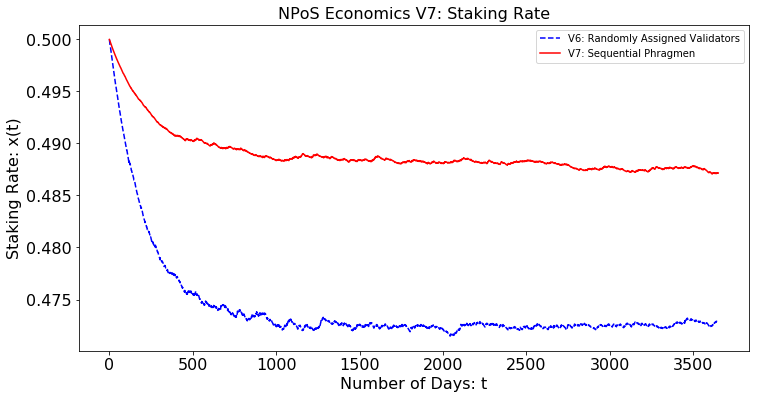

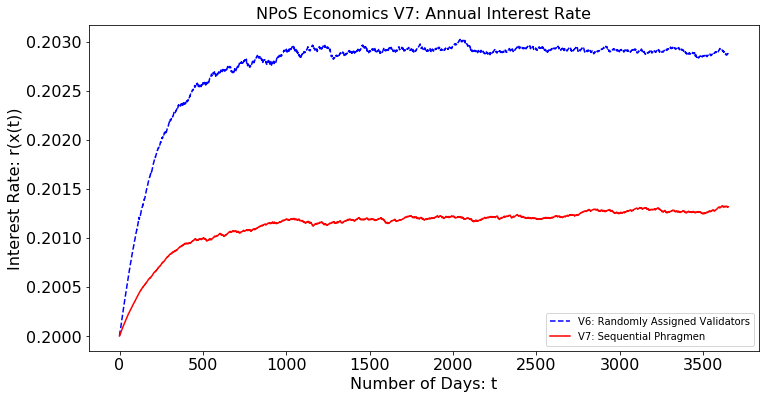

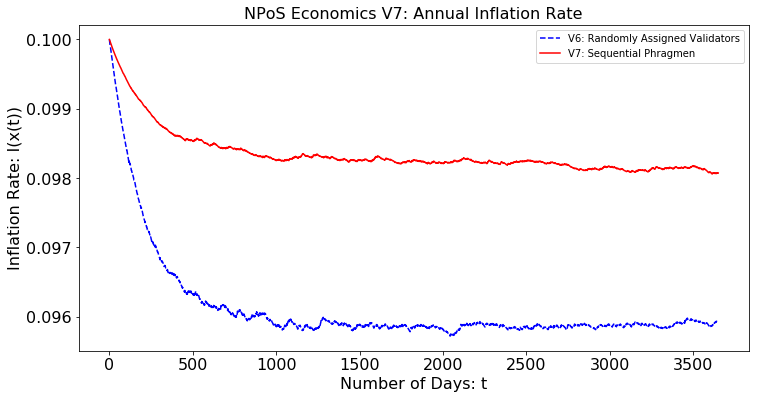

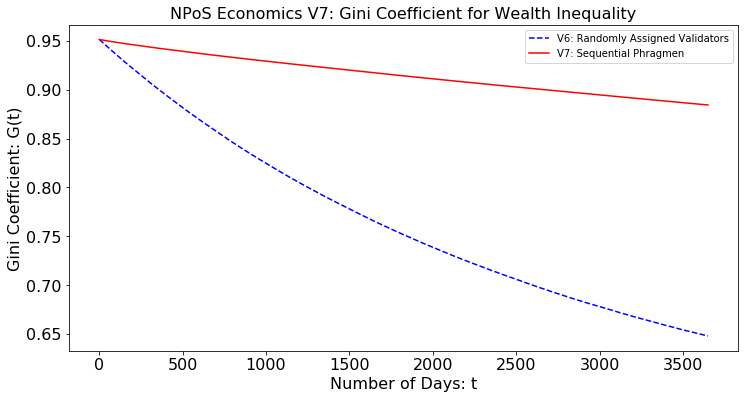

In [33]:
# Run the summary plots
summaryPlots(t, x, x6[0:x.shape[0]], r, r6[0:x.shape[0]], I, I6[0:x.shape[0]], G, G6[0:x.shape[0]])